<a href="https://colab.research.google.com/github/ritwiks9635/image_recognition_and_summarization/blob/main/image_recognition_and_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow easyocr pandas numpy opencv-python -U google-generativeai gradio

In [1]:
import os
import re
import cv2
import json
import base64
import easyocr
import warnings
import unicodedata
import numpy as np
import pandas as pd
from PIL import Image
import gradio as gr
from google import genai
from google.genai import types
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')

In [2]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))


reader = easyocr.Reader(['en'], gpu=False)

IMAGE_FILES = [
    "/content/image1 (1).jpeg",
    "/content/image0.jpeg",
    "/content/error 2.png",
    "/content/error sceenshot.png"
]

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [3]:
def extract_raw_text_easyocr(image_path):
    """
    Performs OCR using EasyOCR and returns a single, consolidated string of text.
    """
    try:
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}. Skipping.")
            return ""

        img = cv2.imread(image_path)
        if img is None:
            return ""

        results = reader.readtext(img, detail=0)

        return "\n".join(results).strip()

    except Exception as e:
        print(f"❌ Error during EasyOCR processing of {image_path}: {e}")
        return ""

In [4]:
def extract_raw_text_from_pdf(pdf_path):
    """
    Extracts raw text content from a PDF file using the Gemini API's multimodal capability.

    Args:
        pdf_path (str): The file path to the PDF document.

    Returns:
        str: The raw text content extracted from the PDF, or an error message.
    """
    GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY")
    if not GEMINI_API_KEY:
        GEMINI_API_KEY = os.environ.get("GOOGLE_API_KEY")
        if not GEMINI_API_KEY:
            return "ERROR: API key not set. Please set the GEMINI_API_KEY environment variable."

    try:
        client = genai.Client(api_key=GEMINI_API_KEY)
    except Exception as e:
        return f"ERROR: Could not initialize Gemini Client: {e}"

    if not os.path.exists(pdf_path):
        return f"ERROR: File not found at path: {pdf_path}"

    try:
        with open(pdf_path, "rb") as f:
            pdf_data_base64 = base64.b64encode(f.read()).decode('utf-8')
        mime_type = "application/pdf"
    except Exception as e:
        return f"ERROR: Could not read PDF file: {e}"

    prompt = (
        "You are an expert document parser. Read the entire provided PDF document "
        "and extract ALL raw text content, preserving the general structure and line breaks. "
        "Do not summarize or analyze; just output the raw, extracted text."
    )

    contents = [
        {"text": prompt},
        {
            "inlineData": {
                "data": pdf_data_base64,
                "mimeType": mime_type
            }
        }
    ]

    MODEL_NAME = 'gemini-2.5-flash'

    try:
        print(f"✅ Sending PDF '{os.path.basename(pdf_path)}' to Gemini for text extraction...")
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=contents
        )

        return response.text

    except Exception as e:
        return f"ERROR: Gemini API call failed during PDF extraction: {e}"

In [ ]:
# pdf_path = "/content/INVOICE----.pdf"
# extract_raw_text_from_pdf(pdf_path)

✅ Sending PDF 'INVOICE----.pdf' to Gemini for text extraction...


'EXPORTER:\nJ.B.P LIMITED,\nSIR MATHURADAS VASANJI ROAD,\nJ.B. NAGAR, ANDHERI (EAST),\nMUMBAI 400 059, INDIA.\nINVOICE NO. :\nDATE\n:\nMANUFACTURER:\nCONSIGNEE :\nRASHTRIYA\nBAR-LEV INDUSTRIAL PARK,\nPOSTAL CODE 2015600\nMISGAV, ISRAEL\nVAT Number: 514189810\nPRE CARRIAGE BY:\nPLACE OF RECEIPT:\nICD TUMB\nVESSEL/VOYAGE NO.:\nPORT OF DISCHARGE:\nHAIFA, ISRAEL\nINVOICE\n9325260173-178\n19.09.2025\nΡ.Ο.ΝΟ.PO25003552 DTD 26/08/2025\nΡ.Ο.ΝΟ.PO25002200 DTD 17/06/2025\nΡ.Ο.ΝΟ.PO25003158 DTD 16/07/2025\nΡ.Ο.ΝΟ.PO25002200 DTD 17/06/2025\nΡ.Ο.ΝΟ.PO25001868 DTD 22.04.2025\nΡ.Ο.ΝΟ.PO25002348 DTD 17.06.2025\nΡ.Ο.ΝΟ.PO25002348 DTD 17.06.2025\nJ.B.P LIMITED,\nPLOT NO.3810-21, PLASTIC ZONE\nGIDC, SARIGAM, TAL.UMBERGAON\nDIST VALSAD, GUJARAT-396155\nBUYER IF OTHER THAN CONSIGNEE\nCOUNTRY OF ORIGIN\nPORT OF LOADING:\nNHAVA SHEVA, INDIA\nTERMS OF PAYMENT :\nOF GOODS:\nINDIA\nCASH AGAINST DOCUMENTS THROUGH HDFC BANK LTD.,\nCOUNTRY OF FINAL\nDESTINATION:\nISRAEL\nVISHAL HALL BRANCH, SIR M.V. ROAD, ANDHERI 

In [5]:
def clean_extracted_text(text: str) -> str:
    """
    Cleans and normalizes raw text extracted from PDFs or OCR outputs.
    - Removes control chars, extra spaces/newlines.
    - Fixes broken words, page headers, and non-ASCII artifacts.
    - Keeps logical paragraph breaks.
    """

    if not text:
        return ""

    # 1️⃣ Normalize unicode (convert fancy quotes, dashes, etc. to standard ASCII)
    text = unicodedata.normalize("NFKC", text)

    # 2️⃣ Remove control & non-printable characters
    text = re.sub(r"[\x00-\x1F\x7F-\x9F]", " ", text)

    # 3️⃣ Remove excessive whitespace & invisible spaces
    text = re.sub(r"[\u200B-\u200D\uFEFF]", "", text)  # zero-width chars
    text = re.sub(r"[ \t\r\f\v]+", " ", text)

    # 4️⃣ Fix hyphenated line breaks: e.g., "co-\noperation" → "cooperation"
    text = re.sub(r"-\n\s*", "", text)

    # 5️⃣ Join broken lines inside paragraphs (e.g., mid-sentence newlines)
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)

    # 6️⃣ Collapse 3+ newlines → 2 (keep paragraph spacing)
    text = re.sub(r"\n{3,}", "\n\n", text)

    # 7️⃣ Trim repeated headers/footers if patterns like "Page X of Y" appear
    text = re.sub(r"Page\s*\d+\s*(of\s*\d+)?", "", text, flags=re.IGNORECASE)

    # 8️⃣ Remove stray punctuation lines or watermark leftovers
    text = re.sub(r"^\s*[\-–—_=]{3,}\s*$", "", text, flags=re.MULTILINE)

    return text.strip()


In [ ]:
# text = extract_raw_text_easyocr("/content/PHOTO-2025-10-07-13-32-50 (1).jpg")
# clean_text = clean_extracted_text(text)
# print(clean_text)

In [6]:
def process_extracted_text_with_ai(raw_text):
    """
    Uses Gemini AI to analyze any extracted text (from OCR or PDF) and produce a structured
    summary of the issue, topic, or problem — across all document types (not just SAP).

    Returns a dict with:
        - Subject (Brief Description of the issue)
        - Details Issue Description
    """

    if not raw_text or len(raw_text.strip()) == 0:
        return {
            "Subject (Brief Description of the issue)": "No valid text extracted",
            "Details Issue Description": "The OCR or PDF extraction returned empty or unreadable text."
        }

    summary_schema = types.Schema(
        type=types.Type.OBJECT,
        properties={
            "Subject": types.Schema(
                type=types.Type.STRING,
                description=(
                    "A concise, domain-agnostic summary of the main issue, topic, or subject "
                    "found in the text (e.g., 'Invoice Processing Delay', 'Server Connection Error', "
                    "'Customer Complaint about Refund', 'Manufacturing Quality Alert')."
                ),
            ),
            "Details_Issue_Description": types.Schema(
                type=types.Type.STRING,
                description=(
                    "A detailed, structured explanation of the issue, analysis, and key insights. "
                    "Use markdown-style headers for clarity, such as:\n"
                    "**Summary:** ...\n"
                    "**Context / Background:** ...\n"
                    "**Error / Problem Description:** ...\n"
                    "**Possible Causes or Impact:** ...\n"
                    "**Recommended Action or Expected Outcome:** ..."
                ),
            ),
        },
        required=["Subject", "Details_Issue_Description"],
    )

    system_instruction = (
        "You are a multi-domain AI Support & Analysis Expert. "
        "You analyze raw text extracted from user documents (OCR images, PDFs, or text files) "
        "and create a clear, structured issue summary — regardless of the document type. "
        "The content may include SAP errors, IT logs, invoices, HR memos, manufacturing reports, "
        "financial statements, or general correspondence.\n\n"
        "Your task is to:\n"
        "1. Identify the main issue or topic in the text.\n"
        "2. Write a detailed description explaining what it’s about, the context, any relevant data, "
        "and what actions or outcomes are expected.\n"
        "3. Always stay factual and grounded in the text; do not hallucinate or infer unsupported details."
    )

    prompt = (
        f"Analyze the following extracted text and summarize the main issue or topic:\n\n"
        f"RAW TEXT:\n---\n{raw_text[:10000]}\n---"
    )

    try:
        response = client.models.generate_content(
            model='gemini-2.5-flash',
            contents=prompt,
            config=types.GenerateContentConfig(
                system_instruction=system_instruction,
                response_mime_type="application/json",
                response_schema=summary_schema,
            ),
        )

        summary_json = json.loads(response.text)

        return {
            "Subject (Brief Description of the issue)": summary_json.get("Subject", "Error"),
            "Details Issue Description": summary_json.get("Details_Issue_Description", "Error retrieving details."),
        }

    except Exception as e:
        return {
            "Subject (Brief Description of the issue)": "AI Summarization Failed (API Error)",
            "Details Issue Description": f"An error occurred during AI processing: {e}",
        }


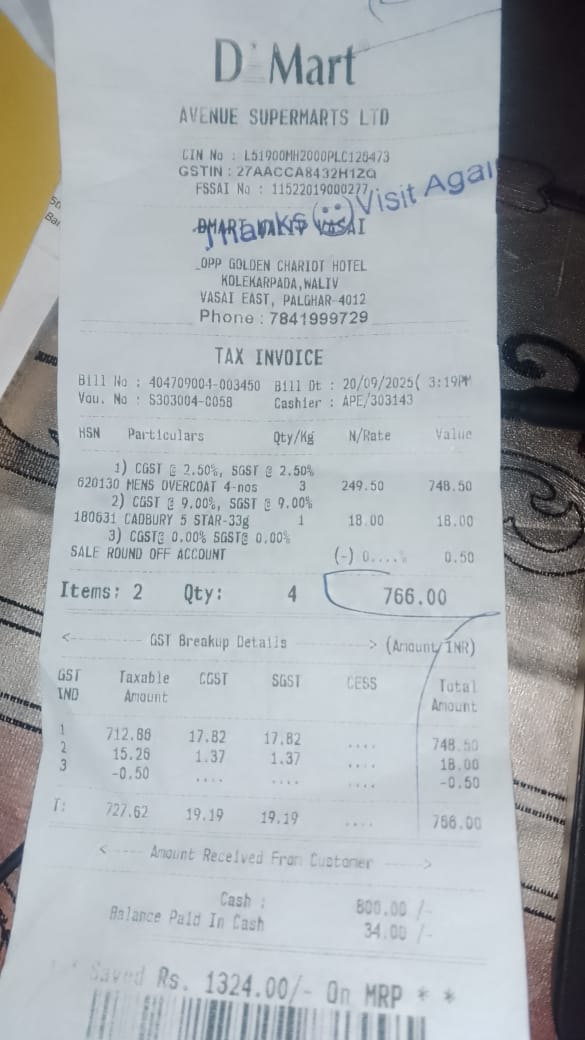


**Subject:** Information Provided is a Sales Invoice, Not an SAP Error Message

**Details:**
**Diagnosis/Analysis:** The provided raw OCR text has been analyzed and identified as a sales invoice from "D' Mart AVENUE SUPERMARTS Ltd". It contains transactional details such as item particulars (e.g., "FCNS OVERCOAT", "LAdBURy STAR-JJg"), quantities, prices, GST breakup, date, time, and payment information. Crucially, the text does not contain any typical SAP error codes (e.g., F5562, M8081, V1300), system response messages, error diagnostics, or any other indicators commonly found in SAP error screenshots. Therefore, no SAP error analysis can be performed based on the provided content. **Requirements/Context:** Based on the input, there is no SAP error to diagnose. The document appears to be a customer-facing sales receipt. If this document is intended to be processed within an SAP system (e.g., for goods receipt, invoice verification, or financial postings), any potential issues would arise during the data entry or automated processing of this information into SAP, rather than being an error *from* SAP itself visible in this text. **Expected Outcome:** Without an SAP error message, there is no specific error to resolve. If the goal was to analyze a potential problem with processing this invoice in SAP, further context or an actual SAP error message from the system would be required to identify the root cause and propose a solution.


In [ ]:
# image_path = "/content/PHOTO-2025-10-07-13-32-50 (1).jpg"
# display(Image.open(image_path))
# text = extract_raw_text_easyocr(image_path)
# raw_text = clean_extracted_text(text)

# summary_dict = process_extracted_text_with_ai(raw_text)

# markdown_output = f"""
# **Subject:** {summary_dict.get("Subject (Brief Description of the issue)", "N/A")}

# **Details:**
# {summary_dict.get("Details Issue Description", "N/A")}
# """

# display(Markdown(markdown_output))

In [7]:
def extract_text_pipeline(file_path: str) -> str:
    """
    Detects file type by extension (.pdf, .png, .jpg, etc.),
    calls appropriate extraction function, and cleans text.
    """
    if not file_path or not os.path.exists(file_path):
        return "ERROR: Invalid or missing file path."

    ext = os.path.splitext(file_path)[1].lower().strip()
    print(f"📂 Detected file extension: {ext}")

    if ext in [".png", ".jpg", ".jpeg", ".tiff", ".bmp", ".webp"]:
        print("🖼️ Running OCR pipeline...")
        raw_text = extract_raw_text_easyocr(file_path)

    elif ext == ".pdf":
        print("📄 Running PDF extraction pipeline...")
        raw_text = extract_raw_text_from_pdf(file_path)

    else:
        return f"ERROR: Unsupported file type '{ext}'. Please upload an image or PDF."

    clean_text = clean_extracted_text(raw_text)
    summary_dict = process_extracted_text_with_ai(clean_text)
    subject = summary_dict.get("Subject (Brief Description of the issue)", "Error")
    details = summary_dict.get("Details Issue Description", "Error retrieving details.")
    return subject, details

In [11]:
file_path = "/content/error sceenshot.png"

subject, details = extract_text_pipeline(file_path)

markdown_output = f"""
**Subject:** {subject}

**Details:**
{details}
"""

display(Markdown(markdown_output))

📂 Detected file extension: .png
🖼️ Running OCR pipeline...



**Subject:** SAP Runtime Error: DDIC_TYPE_REF_ACCESS_ERROR

**Details:**
**Summary:** An internal SAP kernel error occurred, leading to the termination of ABAP program "SAPLV61A" due to an inconsistent DDIC structure description, specifically related to the dictionary-type KOMP INCL. **Context / Background:** The error is categorized as an "Internal Kernel Error" and occurred on 12.10.2020 at 09:10:34. The application component is listed as "Not assigned". **Error / Problem Description:** The core issue is an "Internal error in the DDIC structure description." The ABAP program "SAPLV61A" was terminated because the ABAP processor detected a system error. The error analysis indicates that the structure description of the dictionary-type "KOMP INCL" is incorrect because it refers to type "KOMP", resulting in an "abap type abap Tength inconsistent" error. **Possible Causes or Impact:** The error points to an internal inconsistency within the SAP kernel's handling of Data Dictionary (DDIC) structure descriptions, specifically involving types "KOMP INCL" and "KOMP". This inconsistency caused the termination of the program "SAPLV61A". **Recommended Action or Expected Outcome:** The provided text does not specify any recommended actions or expected outcomes.


In [ ]:
custom_css = """
/* General Gradio element styling for a clean, box-shadow-free look */
.gr-box, .gr-textbox {
    box-shadow: none !important;
    border-color: #e5e7eb !important;
}

/* Style for the Subject and Detailed Description fields */
#subject_field, #details_field {
    border-radius: 6px;
    padding: 0;
}

/* Style the Attachments section to look like the image */
#attachments_box {
    border: 2px dashed #d1d5db !important;
    border-radius: 8px;
    padding: 20px;
    background-color: #f9fafb;
    text-align: center;
}

/* Container for Detailed Description and Buttons (to match image layout) */
#details_container {
    position: relative;
}
#action_buttons {
    position: absolute;
    top: 5px; /* Adjust as needed */
    right: 5px; /* Adjust as needed */
    display: flex;
    gap: 8px;
    z-index: 10;
}
#action_buttons button {
    background-color: #ffffff;
    border: 1px solid #d1d5db;
    color: #374151;
    font-weight: 500;
    padding: 4px 12px;
    border-radius: 4px;
    display: flex;
    align-items: center;
    gap: 4px;
}
#action_buttons button:hover {
    background-color: #f3f4f6;
}
"""

with gr.Blocks(css=custom_css, title="AI SAP Ticket Generator") as demo:
    gr.Markdown("# 🤖 AI SAP Error Ticket Generator")
    gr.Markdown("Upload an SAP error screenshot to automatically generate a structured support ticket summary.")

    with gr.Column(variant="panel"):


        gr.Markdown("## Subject *")
        subject_output = gr.Textbox(
            label="",
            value="Brief description of the issue",
            placeholder="Brief description of the issue",
            interactive=False,
            elem_id="subject_field"
        )


        gr.Markdown("## Detailed Issue Description *")
        with gr.Column(elem_id="details_container"):
            with gr.Row(elem_id="action_buttons"):
                gr.Button("🔍 AI Search", size="sm")
                gr.Button("📝 Grammar", size="sm")

            details_output = gr.Textbox(
                label="",
                value="Provide detailed description of your issue, requirements, and expected outcome...",
                placeholder="Provide detailed description of your issue, requirements, and expected outcome...",
                lines=10,
                interactive=False,
                elem_id="details_field"
            )


    gr.Markdown("## Attachments")
    with gr.Group(elem_id="attachments_box"):
        image_input = gr.File(
            label="",
            file_count="single",
            file_types=["image"],
            type="filepath",
            interactive=True
        )
        gr.Markdown("Drag and drop files here, or click to browse")

    process_btn = gr.Button("Generate AI Summary", variant="primary")

    process_btn.click(
        fn=mock_ocr_and_process,
        inputs=[image_input],
        outputs=[subject_output, details_output]
    )

    gr.Markdown("---")
    gr.Markdown("Powered by Google Gemini 2.5 Flash for SAP analysis.")

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dc0f571b2f3a29cf2c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install pdfplumber pytesseract pdf2image pillow pandas tqdm layoutparser pdfminer.six --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 53.8 MB/s eta 0:00:00


In [ ]:
# import os
# import re
# import pdfplumber
# import pandas as pd
# from tqdm import tqdm
# from pdf2image import convert_from_path
# import pytesseract
# from io import BytesIO


In [ ]:
# def extract_text_hybrid(pdf_path, min_text_len=500):
#     """
#     Hybrid extraction: use pdfplumber + OCR fallback.
#     Also collects positional text blocks for layout understanding.
#     """
#     full_text = []
#     layout_blocks = []

#     with pdfplumber.open(pdf_path) as pdf:
#         for page in tqdm(pdf.pages, desc="Extracting text & layout"):
#             text = page.extract_text()
#             if text:
#                 full_text.append(text)


#             words = page.extract_words()
#             if words:
#                 layout_blocks.extend(words)


#             if not text or len(text.strip()) < 50:
#                 image = page.to_image(resolution=300).original
#                 ocr_text = pytesseract.image_to_string(image)
#                 if ocr_text.strip():
#                     full_text.append(ocr_text)

#     text_joined = "\n".join(full_text)
#     return text_joined, layout_blocks


In [ ]:
# def extract_invoice_fields(text):
#     text = re.sub(r'\s+', ' ', text)

#     patterns = {
#         "Invoice No": [r"(?:Invoice\s*(?:No|#|Number)[:\-]?\s*)([A-Za-z0-9\-\/]+)"],
#         "Date": [r"(?:Date|Dated)[:\-]?\s*(\d{1,2}[./-]\d{1,2}[./-]\d{2,4})"],
#         "GSTIN": [r"GSTIN\s*[:\-]?\s*([0-9A-Z]{15})"],
#         "PAN": [r"PAN\s*[:\-]?\s*([A-Z]{5}\d{4}[A-Z])"],
#         "Total Amount": [
#             r"Total\s*(?:Amount|Payable|Due)\s*[:\-]?\s*(?:INR|Rs\.?|USD)?\s*([\d,]+\.\d{2})",
#             r"Grand\s*Total\s*[:\-]?\s*(?:INR|Rs\.?|USD)?\s*([\d,]+\.\d{2})"
#         ],
#         "Buyer": [
#             r"(?:Bill\s*To|Billed\s*To|Customer\s*Name)[:\-]?\s*(.*?)\s+(?:Ship\s*To|GSTIN|PAN|$)"
#         ],
#         "Seller": [
#             r"(?:From|Supplier|Vendor|Seller)[:\-]?\s*(.*?)\s+(?:Bill\s*To|Customer|GSTIN|PAN|$)"
#         ]
#     }

#     extracted = {}
#     for field, pats in patterns.items():
#         for p in pats:
#             match = re.search(p, text, re.IGNORECASE)
#             if match:
#                 extracted[field] = match.group(1).strip()
#                 break
#         if field not in extracted:
#             extracted[field] = None

#     return extracted


In [ ]:
# def extract_line_items_from_layout(blocks):
#     """
#     Try to identify tabular line items by y-position grouping.
#     Works even when invoice tables are images of text.
#     """
#     if not blocks:
#         return None

#     df = pd.DataFrame(blocks)
#     df['y0_round'] = df['top'].round(-1)

#     grouped = df.groupby('y0_round')
#     rows = []
#     for _, group in grouped:
#         line = " ".join(group.sort_values('x0')['text'])
#         if re.search(r'\d+\.\d{2}', line) and len(line.split()) > 3:
#             rows.append(line)

#     if not rows:
#         return None

#     split_rows = [re.split(r'\s{2,}', row) for row in rows]
#     max_cols = max(len(r) for r in split_rows)
#     df_table = pd.DataFrame(split_rows, columns=[f"Col_{i+1}" for i in range(max_cols)])
#     return df_table


In [ ]:
# def extract_invoice_data(pdf_path):
#     text, layout_blocks = extract_text_hybrid(pdf_path)
#     meta = extract_invoice_fields(text)
#     items_df = extract_line_items_from_layout(layout_blocks)

#     print("\n✅ Extracted Metadata:")
#     for k, v in meta.items():
#         print(f"{k}: {v}")

#     if items_df is not None:
#         print("\n🧾 Extracted Line Items:")
#         display(items_df.head())
#     else:
#         print("\n⚠️ No line-item table detected (possibly non-tabular invoice).")

#     return {"metadata": meta, "items": items_df}


In [ ]:
# from google.colab import files
# uploaded = files.upload()
# pdf_path = list(uploaded.keys())[0]

# data = extract_invoice_data(pdf_path)


Saving INVOICE----.pdf to INVOICE---- (1).pdf


Extracting text & layout: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]



✅ Extracted Metadata:
Invoice No: None
Date: None
GSTIN: None
PAN: None
Total Amount: None
Buyer: None
Seller: None

🧾 Extracted Line Items:


,Col_1
0,"SIR J.B. MATHURADAS NAGAR, ANDHERI VASANJI (EA..."
1,POSTAL CODE 2015600 P.O.NO.PO25002200 P.O.NO.P...
2,"MISGAV , ISRAEL P.O.NO.PO25002348 DTD 17.06.2025"
3,VAT Number: 514189810 P.O.NO.PO25002348 DTD 17...
4,1.6 MM X 82 MM (Part Number 9902826) WOODEN BO...
